In [41]:
import pandas as pd
import georinex as gr
import misc
from plots import *
import copy

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from logparser import LogReader, PosReader, RinexReader

# Prepare the data

In [42]:
# Load log files
measurements_log = ['Raw', 'Fix']
measurements_RINEX = sum([[f"{y}{x}" for y in ['C', 'L', 'D', 'S']] for x in ['1C', '5Q', '2I', '5P']], [])
# measurements_RINEX = ['L1C', 'L5Q']
# # 'C1C', 'C5Q', 'C2I', 'C5P'

logs = []

log = LogReader(manufacturer="Google", device="Pixel 7", acronym='GP7', specifiedTags=measurements_log, mode="logger", 
                filepath="../.data/2023_Dataset_Hervanta/S2_dynamic_campus/raw/log_GooglePixel7_20230801110405_modified.txt")
log.ref = RinexReader('Reference', 
            filepath='../.data/2023_Dataset_Hervanta/S2_dynamic_campus/_reference/rover/NMND17420010S_2023-08-01_08-14-05.23O',
              tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
              meas=measurements_RINEX, sampling=1)
log.pos = PosReader('../.data/2023_Dataset_Hervanta/S2_dynamic_campus/_reference/rover/NMND17420010S_2023-08-01_08-14-05.pos')
logs.append(log)

log = LogReader(manufacturer="Google", device="Pixel Watch", acronym='GPW', specifiedTags=measurements_log, mode="mimir", 
                filepath="../.data/2023_Dataset_Hervanta/S2_dynamic_campus/raw/log_GooglePixelWatch_20230801110404_modified.txt")
log.ref = RinexReader('Reference', 
            filepath='../.data/2023_Dataset_Hervanta/S2_dynamic_campus/_reference/rover/NMND17420010S_2023-08-01_08-14-05.23O',
              tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
              meas=measurements_RINEX, sampling=1)
log.pos = PosReader('../.data/2023_Dataset_Hervanta/S2_dynamic_campus/_reference/rover/NMND17420010S_2023-08-01_08-14-05.pos')
logs.append(log)

log = LogReader(manufacturer="OnePlus", device="Nord 2", acronym='ON2', specifiedTags=measurements_log, mode="mimir", 
                filepath="../.data/2023_Dataset_Hervanta/S2_dynamic_campus/raw/log_OnePlusNord2_20230811103018_modified.txt")
log.ref = RinexReader('Reference', 
            filepath='../.data/2023_Dataset_Hervanta/S2_dynamic_campus/_reference/rover/NMND17420010S_2023-08-11_07-40-20.23O',
              tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
              meas=measurements_RINEX, sampling=1)
log.pos = PosReader('../.data/2023_Dataset_Hervanta/S2_dynamic_campus/_reference/rover/NMND17420010S_2023-08-11_07-40-20.pos')
logs.append(log)

log = LogReader(manufacturer="Samsung", device="A52", acronym='A52', specifiedTags=measurements_log, mode="mimir", 
                filepath="../.data/2023_Dataset_Hervanta/S2_dynamic_campus/raw/log_SamsungA52_20230811101903_modified.txt")
log.ref = RinexReader('Reference', 
            filepath='../.data/2023_Dataset_Hervanta/S2_dynamic_campus/_reference/rover/NMND17420010S_2023-08-11_07-29-33.23O',
              tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
              meas=measurements_RINEX, sampling=1)
log.pos = PosReader('../.data/2023_Dataset_Hervanta/S2_dynamic_campus/_reference/rover/NMND17420010S_2023-08-11_07-29-33.pos')
logs.append(log)

log = LogReader(manufacturer="Xiaomi", device="11T", acronym='X11', specifiedTags=measurements_log, mode="mimir", 
                filepath="../.data/2023_Dataset_Hervanta/S2_dynamic_campus/raw/log_Xiaomi11T_20230801111451_modified.txt")
log.ref = RinexReader('Reference', 
            filepath='../.data/2023_Dataset_Hervanta/S2_dynamic_campus/_reference/rover/NMND17420010S_2023-08-01_08-24-35.23O',
              tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
              meas=measurements_RINEX, sampling=1)
log.pos = PosReader('../.data/2023_Dataset_Hervanta/S2_dynamic_campus/_reference/rover/NMND17420010S_2023-08-01_08-24-35.pos')
logs.append(log)

device_list = [log.device for log in logs]

In [43]:
# Output folder
output = '../.output/S2'

In [44]:
log.raw.loc[log.raw['prn'].isin(['C20-L5']), ['CarrierFrequencyHz']]


,CarrierFrequencyHz
datetime,
2023-08-01 08:14:54.293,1.176450e+09
2023-08-01 08:14:56.307,1.176450e+09
2023-08-01 08:14:59.151,1.176450e+09
2023-08-01 08:15:01.126,1.176450e+09
2023-08-01 08:15:02.142,1.176450e+09
...,...
2023-08-01 08:24:12.161,1.176450e+09
2023-08-01 08:24:13.158,1.176450e+09
2023-08-01 08:24:17.149,1.176450e+09


In [45]:
log.pos.df

,provider,timestamp,latitude,longitude,altitude
datetime,,,,,
2023-08-01 08:14:36,REF,1.690878e+09,61.449224,23.856273,163.0371
2023-08-01 08:14:37,REF,1.690878e+09,61.449224,23.856273,163.0365
2023-08-01 08:14:38,REF,1.690878e+09,61.449224,23.856272,163.0390
2023-08-01 08:14:39,REF,1.690878e+09,61.449225,23.856269,163.0332
2023-08-01 08:14:40,REF,1.690878e+09,61.449222,23.856274,162.7518
...,...,...,...,...,...
2023-08-01 08:24:31,REF,1.690878e+09,61.449222,23.856280,163.1328
2023-08-01 08:24:32,REF,1.690878e+09,61.449220,23.856276,163.0274
2023-08-01 08:24:33,REF,1.690878e+09,61.449219,23.856277,163.0225


In [46]:
log.ref.df

,time,sv,signal,doppler,phase,pseudorange,snr,prn,system,frequency,pseudorange_rate,pseudorange_error,phase_rate,phase_error,doppler_error
0,2023-08-01 08:14:54,C05,2I,28.398,2.084847e+08,4.003730e+07,40.407,C05-L1,C,L1,NaN,NaN,NaN,NaN,NaN
1,2023-08-01 08:14:54,C08,2I,-1286.781,2.034746e+08,3.907515e+07,43.951,C08-L1,C,L1,NaN,NaN,NaN,NaN,NaN
2,2023-08-01 08:14:54,C13,2I,-1032.277,1.988116e+08,3.817968e+07,48.422,C13-L1,C,L1,NaN,NaN,NaN,NaN,NaN
3,2023-08-01 08:14:54,C19,2I,3001.274,1.262413e+08,2.424329e+07,49.173,C19-L1,C,L1,NaN,NaN,NaN,NaN,NaN
4,2023-08-01 08:14:54,C19,5P,2261.795,9.513597e+07,2.424330e+07,50.647,C19-L5,C,L5,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24800,2023-08-01 08:24:23,R09,1C,-3136.277,1.191103e+08,2.230561e+07,43.912,R09-L1,R,L1,587.258,0.167,3135.855,0.734,-0.576
24801,2023-08-01 08:24:23,R10,1C,-67.903,1.156311e+08,2.169217e+07,40.150,R10-L1,R,L1,12.621,0.141,67.392,0.957,-0.727
24802,2023-08-01 08:24:23,R17,1C,-3981.041,1.232831e+08,2.303847e+07,45.619,R17-L1,R,L1,743.913,0.026,3980.813,0.179,-0.247
24803,2023-08-01 08:24:23,R18,1C,-1723.238,1.046144e+08,1.959788e+07,51.452,R18-L1,R,L1,322.771,0.105,1722.957,0.570,-0.403


In [47]:
# only keep GPS provider
log.fix = log.fix.loc[log.fix["provider"] == 'GPS']

In [48]:
# Compute ENU errors
ref_enu = [61.44922404, 23.8562781, 162.711]
for log in logs:
    # Convert to ENU based on reference
    log.fix[["east", "north", "up"]] = log.fix.apply(
        lambda row: misc.convert2ENU(row['latitude'], row['longitude'], row['altitude'], ref_enu), 
        axis='columns', result_type='expand')

    # window = 1
    # log.pos.df["latitude_avg"] = log.pos.df["latitude"].rolling(window).mean()
    # log.pos.df["longitude_avg"] = log.pos.df["longitude"].rolling(window).mean()
    # log.pos.df["altitude_avg"] = log.pos.df["altitude"].rolling(window).mean()

    log.pos.df[["east", "north", "up"]] = log.pos.df.apply(
        lambda row: misc.convert2ENU(row['latitude'], row['longitude'], row['altitude'], ref_enu), 
        axis='columns', result_type='expand')

    # Align/interpolates dataframes
    pos_A, pos_B = log.fix[["east", "north", "up"]].align(log.pos.df[["east", "north", "up"]])
    log.diff = pos_B.interpolate(method='time') - pos_A.interpolate(method='time')
    log.diff.dropna(how='all', inplace=True)
    
    log.diff[["2D_error"]] = log.diff.apply(
        lambda row: misc.getHorizontalError(row['east'], row['north']), 
        axis='columns', result_type='expand')
    
    log.diff[["3D_error"]] = log.diff.apply(
        lambda row: misc.get3DError(row['east'], row['north'], row['up']), 
        axis='columns', result_type='expand')

    print(f"--- {log.device} ---")
    print(log.diff[["east", "north", "up", "2D_error", "3D_error"]].describe())

--- Pixel 7 ---
             east       north          up    2D_error    3D_error
count  627.000000  627.000000  627.000000  627.000000  627.000000
mean     0.371880   -0.444763   -6.927663    1.824681    7.572412
std      1.300549    1.969238    3.090132    1.603494    2.468003
min     -6.172954   -6.211736  -20.060630    0.078894    1.564468
25%     -0.010505   -1.351840   -7.954781    0.922860    6.305800
50%      0.329247   -0.965794   -6.629866    1.448422    6.875208
75%      0.807818   -0.008581   -6.038846    2.067478    8.150087
max     10.772448   14.858674   20.332651   15.984926   25.863770
--- Pixel Watch ---
             east       north          up    2D_error    3D_error
count  862.000000  862.000000  862.000000  862.000000  862.000000
mean     0.935102   -0.329131   -4.134536    2.725511    6.345669
std      2.034178    2.443932    5.341635    1.912466    4.053097
min     -9.294852  -11.117086  -34.250484    0.167605    0.496471
25%     -0.028827   -1.728611   -7.23448

In [49]:
log.diff

,east,north,up,2D_error,3D_error
datetime,,,,,
2023-08-01 08:14:55,2.220516,1.263836,-10.387199,2.554990,10.696817
2023-08-01 08:14:56,1.716423,0.907118,-11.191900,1.941384,11.359031
2023-08-01 08:14:57,1.751256,0.606603,-11.258566,1.853339,11.410091
2023-08-01 08:14:58,1.727945,0.271095,-11.324333,1.749082,11.458613
2023-08-01 08:14:59,1.735093,-0.028195,-11.398700,1.735322,11.530035
...,...,...,...,...,...
2023-08-01 08:24:31,0.253807,0.616150,-11.967200,0.666377,11.985739
2023-08-01 08:24:32,0.062892,0.378896,-12.072600,0.384080,12.078708
2023-08-01 08:24:33,0.100659,0.281943,-12.077500,0.299373,12.081210


# Results

In [50]:
center = ref_enu[:2]
extent = [center[1] - 0.001, center[1] + 0.006, center[0] - 0.0005, center[0] + 0.0015]

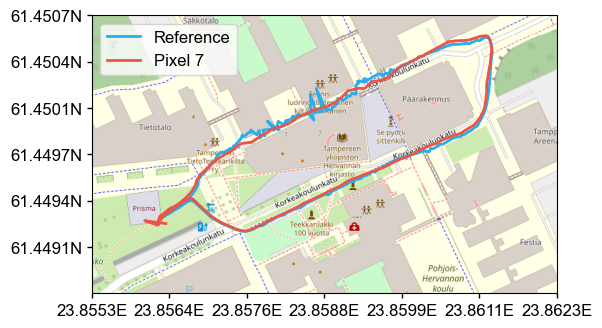

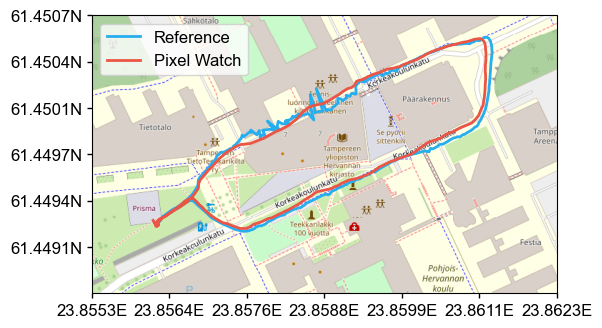

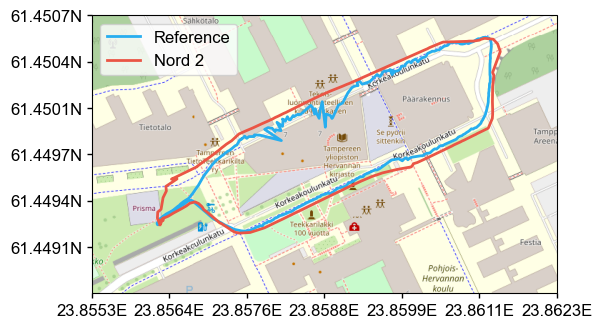

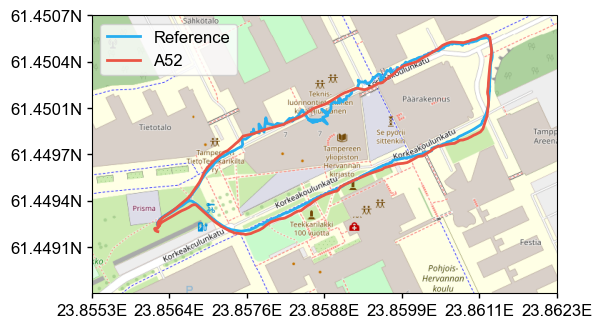

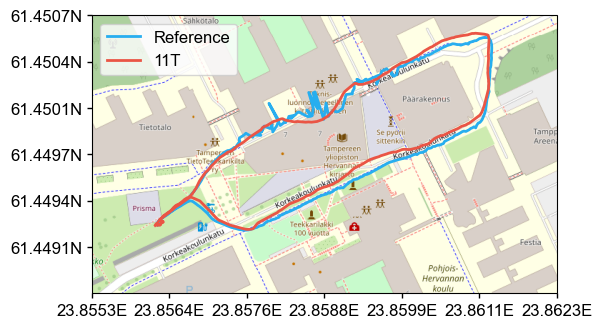

In [51]:

for log in logs:
    locations = {}
    locations['Reference'] = log.pos.df[["latitude", "longitude"]]
    locations[log.device] = log.fix.loc[log.fix['provider'].isin(['GPS']), ["latitude", "longitude"]]
    plotMap(locations=locations, extent=extent, scale=17)

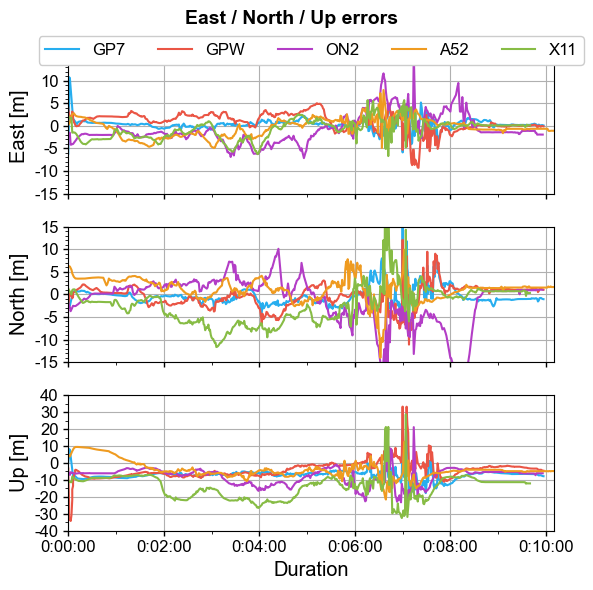

In [52]:
plotENU(logs, lim=[15,15,40], yticks=[1, 5, 1, 5, 5, 10], xticks=[60, 120], mode='difference', save=f"{output}/s2_enu")

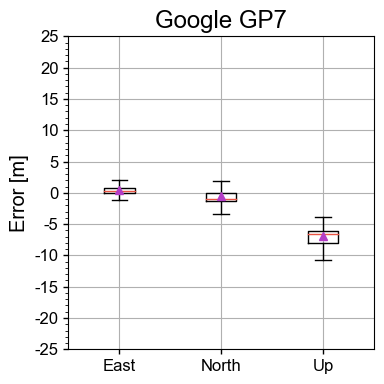

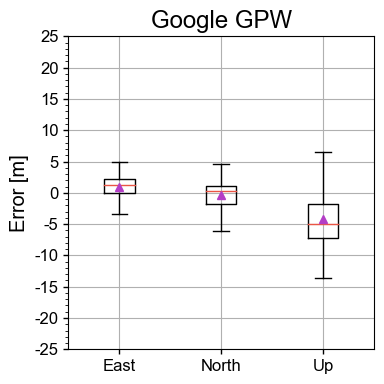

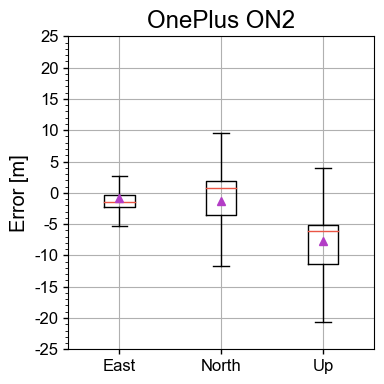

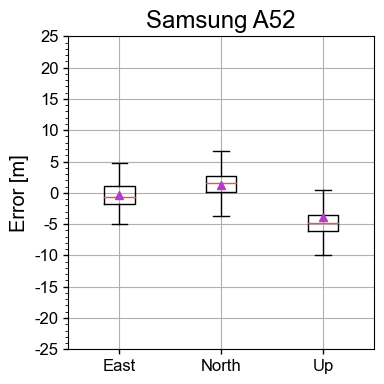

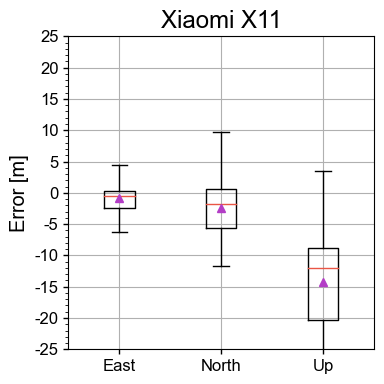

In [53]:
plotStatisticsENU(logs, mode='box', lim=25, ticks=[1, 5])

### Visibility

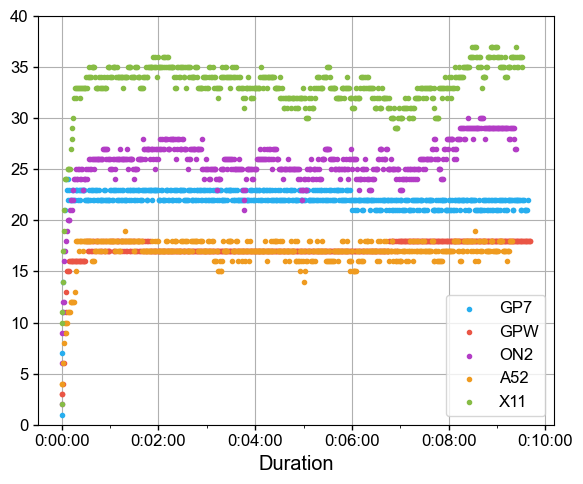

In [54]:
plotTotalSignalsPerEpochs(logs, lim=[0, 40], ticks=[60, 120], mode='signal', save=f"{output}/s2_signals_epoch")

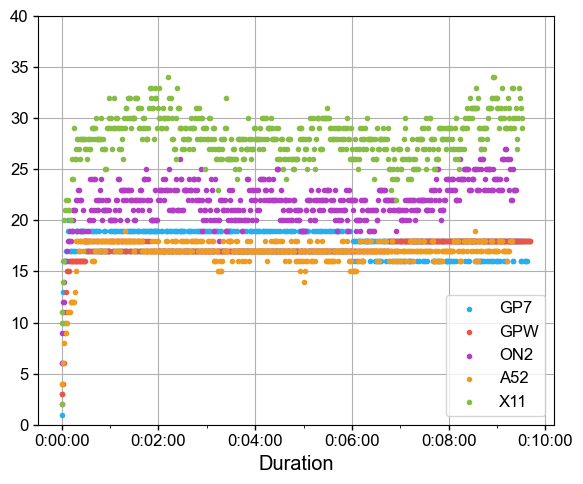

In [55]:
plotTotalSignalsPerEpochs(logs, lim=[0, 40], ticks=[60, 120], mode='satellite', save=f"{output}/s2_sats_epoch")

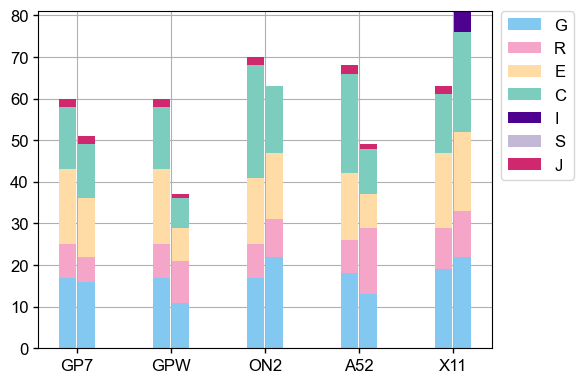

In [56]:
plotBarSignalsPerSystem(logs, save=f"{output}/s2_sats_hist")

In [57]:
df = statsSignalsPerSystem(logs)
print(df.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.3f}".format))

\begin{tabular}{lrrrrrrrrrrrrrr}
\toprule
device &  G &  G\_ref &  R &  R\_ref &  E &  E\_ref &  C &  C\_ref &  I &  I\_ref &  S &  S\_ref &  J &  J\_ref \\
\midrule
   GP7 & 16 &     17 &  6 &      8 & 14 &     18 & 13 &     15 &  0 &      0 &  0 &      0 &  2 &      2 \\
   GPW & 11 &     17 & 10 &      8 &  8 &     18 &  7 &     15 &  0 &      0 &  0 &      0 &  1 &      2 \\
   ON2 & 22 &     17 &  9 &      8 & 16 &     16 & 16 &     27 &  0 &      0 &  0 &      0 &  0 &      2 \\
   A52 & 13 &     18 & 16 &      8 &  8 &     16 & 11 &     24 &  0 &      0 &  0 &      0 &  1 &      2 \\
   X11 & 22 &     19 & 11 &     10 & 19 &     18 & 24 &     14 &  5 &      0 &  0 &      0 &  0 &      2 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_854/473874368.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.3f}".format))


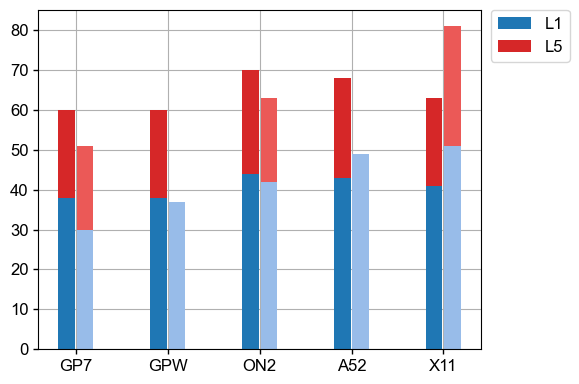

In [58]:
plotBarSignalsPerFrequency(logs, save=f"{output}/s2_freq_hist")

In [59]:
df = statsSignalsPerFrequency(logs)
print(df.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.3f}".format))

\begin{tabular}{lrrrr}
\toprule
device &  L1 &  L1\_ref &  L5 &  L5\_ref \\
\midrule
   GP7 &  30 &      38 &  21 &      22 \\
   GPW &  37 &      38 &   0 &      22 \\
   ON2 &  42 &      44 &  21 &      26 \\
   A52 &  49 &      43 &   0 &      25 \\
   X11 &  51 &      41 &  30 &      22 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_854/3764387841.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.3f}".format))


### Measurements

Pseudoranges

In [60]:
_logs = copy.deepcopy(logs)
stats = []
for log in _logs:
    print(f"--- {log.device} ---")
    log.raw = misc.filterValues(log.raw, 'PseudorangeAcceleration', 300)
    log.raw[list(misc.GnssState_Str.values())] = log.raw.apply(lambda row: misc.getSplitState(row['State'], bits=17, type='tracking'), axis='columns', result_type='expand')
    stats.append(log.raw['PseudorangeAcceleration'].describe(percentiles=[0.5, .667, .95, .997]))
stats = pd.concat(stats, keys=device_list, axis=1).T
stats


--- Pixel 7 ---
Rows removed 7 (0.058%)
--- Pixel Watch ---
Rows removed 15 (0.165%)
--- Nord 2 ---
Rows removed 90 (0.648%)
--- A52 ---
Rows removed 2 (0.022%)
--- 11T ---
Rows removed 131 (0.733%)


,count,mean,std,min,50%,66.7%,95%,99.7%,max
Pixel 7,12018.0,0.124266,9.751511,-153.535509,0.130270,1.423095,12.954853,42.189841,246.958558
Pixel Watch,9068.0,0.412511,18.186163,-296.117558,0.152443,1.971097,20.372765,110.580509,226.721222
Nord 2,13805.0,0.553043,13.839678,-128.523523,0.410159,2.294482,20.209591,70.168420,138.471306
A52,9201.0,0.090261,15.079990,-273.992238,0.105149,1.770599,19.243106,68.167153,195.191331
11T,17734.0,0.280861,13.037994,-99.589489,0.067308,2.030527,21.498014,59.438550,143.734794


In [61]:
print(stats.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.3f}".format))

\begin{tabular}{rrrrrrrrr}
\toprule
    count &  mean &    std &      min &   50\% &  66.7\% &    95\% &   99.7\% &     max \\
\midrule
12018.000 & 0.124 &  9.752 & -153.536 & 0.130 &  1.423 & 12.955 &  42.190 & 246.959 \\
 9068.000 & 0.413 & 18.186 & -296.118 & 0.152 &  1.971 & 20.373 & 110.581 & 226.721 \\
13805.000 & 0.553 & 13.840 & -128.524 & 0.410 &  2.294 & 20.210 &  70.168 & 138.471 \\
 9201.000 & 0.090 & 15.080 & -273.992 & 0.105 &  1.771 & 19.243 &  68.167 & 195.191 \\
17734.000 & 0.281 & 13.038 &  -99.589 & 0.067 &  2.031 & 21.498 &  59.439 & 143.735 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_854/3026797437.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.3f}".format))


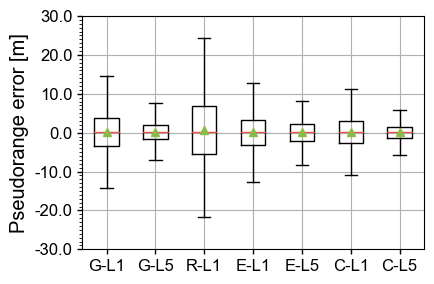

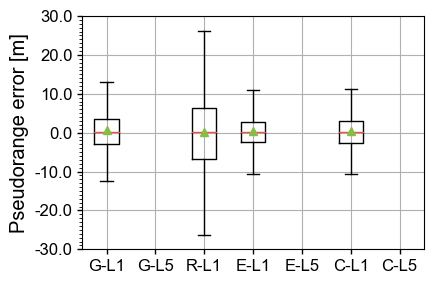

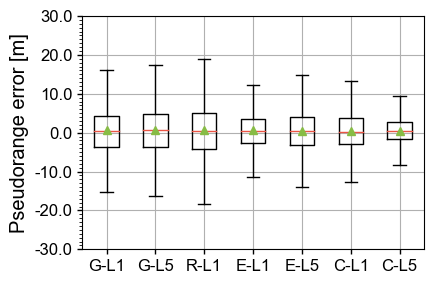

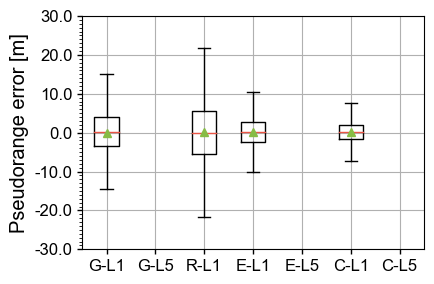

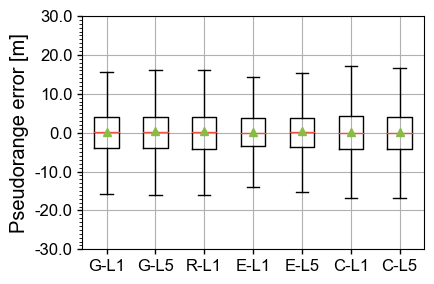

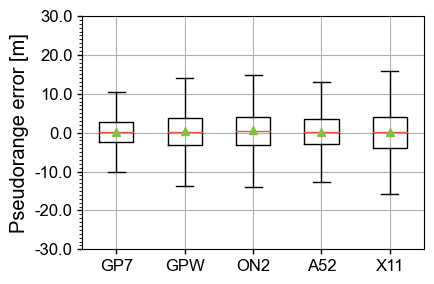

In [62]:

plotStatisticsDataBox(_logs, 
                      'PseudorangeAcceleration', 
                      'Pseudorange error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=30,
                      ticks=[1,10],
                      save=f"{output}/s2_pseudo")


In [63]:
_logs = copy.deepcopy(logs)
stats = []
for log in _logs:
    print(f"--- {log.device} ---")
    log.ref.df = misc.filterValues(log.ref.df, 'pseudorange_error', 300)
    stats.append(log.ref.df['pseudorange_error'].describe(percentiles=[0.5, .667, .95, .997]))
stats = pd.concat(stats, keys=device_list, axis=1).T
stats


--- Pixel 7 ---
Rows removed 1389 (5.376%)
--- Pixel Watch ---
Rows removed 1390 (5.346%)
--- Nord 2 ---
Rows removed 1550 (5.618%)
--- A52 ---
Rows removed 1569 (5.670%)
--- 11T ---
Rows removed 1413 (5.725%)


,count,mean,std,min,50%,66.7%,95%,99.7%,max
Pixel 7,24447.0,0.122704,23.428013,-299.829,0.075,0.120,0.59600,223.673012,299.897
Pixel Watch,24609.0,0.122131,23.350781,-299.829,0.075,0.120,0.59360,223.465976,299.897
Nord 2,26041.0,0.018646,20.820157,-295.142,0.073,0.115,0.55000,189.979120,294.029
A52,26102.0,0.136095,19.585639,-299.977,0.074,0.117,0.60995,153.178263,298.300
11T,23268.0,0.161068,19.905765,-299.723,0.075,0.120,0.61100,200.269388,297.868


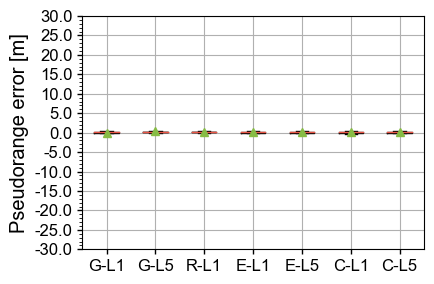

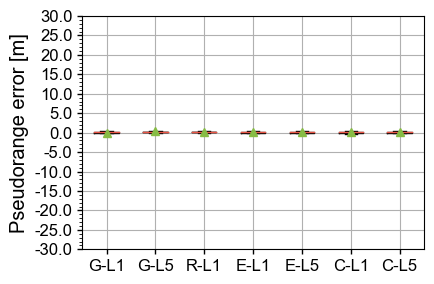

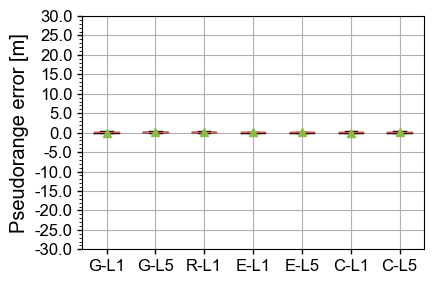

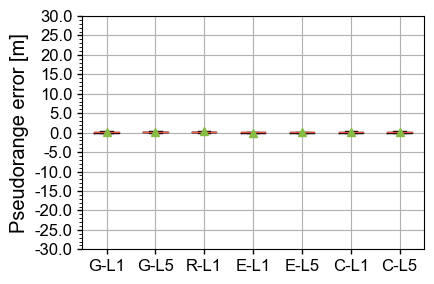

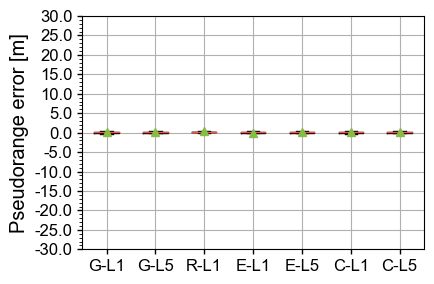

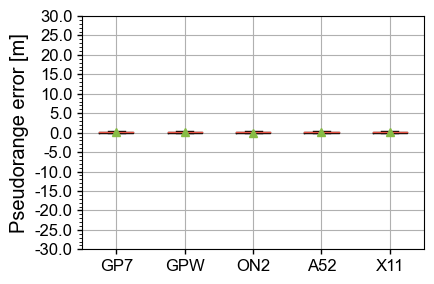

In [64]:

plotStatisticsDataBox(_logs, 
                      'pseudorange_error', 
                      'Pseudorange error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=30,
                      ticks=[1,5],
                      mode='ref')


In [65]:
_logs = copy.deepcopy(logs)
stats = []
for log in _logs:
    log.raw[list(misc.GnssState_Str.values())] = log.raw.apply(lambda row: misc.getSplitState(row['State'], bits=17, type='tracking'), axis='columns', result_type='expand')
    count = log.raw[list(misc.GnssState_Str.values())].count()
    stats.append(log.raw[list(misc.GnssState_Str.values())].sum().div(count))
stats = pd.concat(stats, keys=device_list, axis=1)
stats

,Pixel 7,Pixel Watch,Nord 2,A52,11T
TRACK_UNKNOWN,0.000000,0.000000,0.000000,0.000000,0.000000
TRACK_CODE_LOCK,0.727813,0.634124,1.000000,1.000000,1.000000
TRACK_BIT_SYNC,0.757682,0.852513,0.750172,0.998626,0.681780
TRACK_SUBFRAME_SYNC,0.456173,0.459912,0.603678,0.989218,0.551080
TRACK_TOW_DECODED,0.369536,0.455923,0.815493,0.989218,0.827646
TRACK_MSEC_AMBIGUOUS,0.005239,0.004986,0.038013,0.000000,0.041654
TRACK_SYMBOL_SYNC,0.757995,0.852712,0.750172,0.009408,0.681780
TRACK_GLO_STRING_SYNC,0.024240,0.199043,0.146494,0.214905,0.130700
TRACK_GLO_TOD_DECODED,0.021972,0.192361,0.146494,0.214905,0.130700
TRACK_BDS_D2_BIT_SYNC,0.000000,0.000000,0.000000,0.000000,0.000000


Doppler

In [66]:
_logs = copy.deepcopy(logs)
stats = []
for log in _logs:
    print(f"--- {log.device} ---")
    log.raw = misc.filterValues(log.raw, 'DopplerError', 30)
    #log.raw = misc.filterPercentile(log.raw, 'DopplerError', 0.997)
    stats.append(log.raw['DopplerError'].describe(percentiles=[0.5, .667, .95, .997]).T)
stats = pd.concat(stats, keys=device_list, axis=1).T
stats


--- Pixel 7 ---
Rows removed 0 (0.000%)
--- Pixel Watch ---
Rows removed 0 (0.000%)
--- Nord 2 ---
Rows removed 1 (0.007%)
--- A52 ---
Rows removed 0 (0.000%)
--- 11T ---
Rows removed 0 (0.000%)


,count,mean,std,min,50%,66.7%,95%,99.7%,max
Pixel 7,12738.0,0.075958,0.394933,-5.145190,0.072259,0.147373,0.637539,1.816113,10.059676
Pixel Watch,9991.0,0.098080,0.374276,-6.700270,0.093999,0.186911,0.638722,1.608383,6.036480
Nord 2,14510.0,0.317093,2.073268,-22.043684,0.411657,0.895515,2.427668,10.079438,13.690755
A52,9411.0,0.057992,0.650847,-12.501771,0.061813,0.257186,1.090386,2.109778,7.767997
11T,18909.0,0.006854,1.084866,-19.210938,0.068526,0.349689,1.308547,3.623602,21.976807


In [67]:
print(stats.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.3f}".format))

\begin{tabular}{rrrrrrrrr}
\toprule
    count &  mean &   std &     min &   50\% &  66.7\% &   95\% &  99.7\% &    max \\
\midrule
12738.000 & 0.076 & 0.395 &  -5.145 & 0.072 &  0.147 & 0.638 &  1.816 & 10.060 \\
 9991.000 & 0.098 & 0.374 &  -6.700 & 0.094 &  0.187 & 0.639 &  1.608 &  6.036 \\
14510.000 & 0.317 & 2.073 & -22.044 & 0.412 &  0.896 & 2.428 & 10.079 & 13.691 \\
 9411.000 & 0.058 & 0.651 & -12.502 & 0.062 &  0.257 & 1.090 &  2.110 &  7.768 \\
18909.000 & 0.007 & 1.085 & -19.211 & 0.069 &  0.350 & 1.309 &  3.624 & 21.977 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_854/3026797437.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.3f}".format))


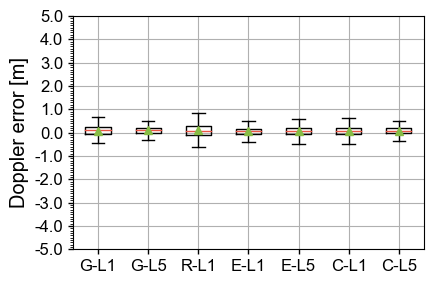

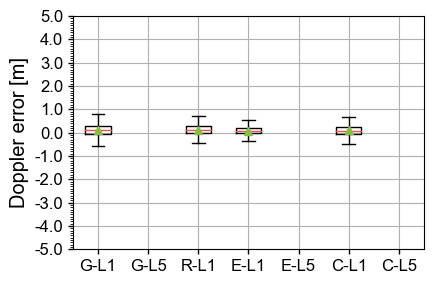

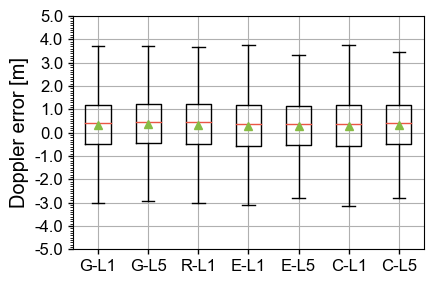

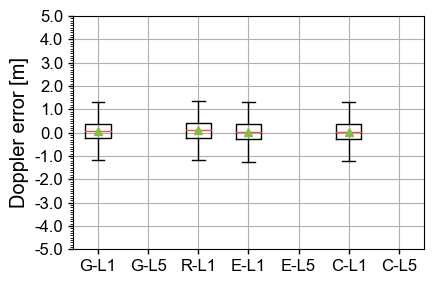

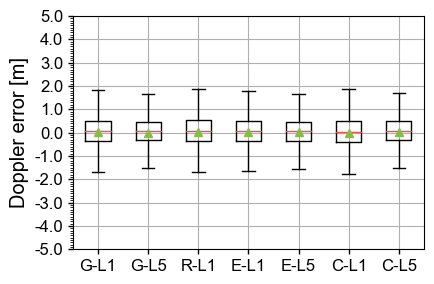

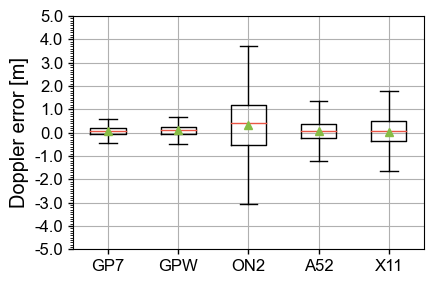

In [68]:

plotStatisticsDataBox(_logs, 
                      'DopplerError', 
                      'Doppler error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=5,
                      ticks=[0.1,1],
                      save=f"{output}/s2_doppler")

In [69]:
_logs = copy.deepcopy(logs)
stats = []
for log in _logs:
    print(f"--- {log.device} ---")
    log.ref.df = misc.filterValues(log.ref.df, 'doppler_error', 30)
    #log.raw = misc.filterPercentile(log.raw, 'DopplerError', 0.997)
    stats.append(log.ref.df['doppler_error'].describe(percentiles=[0.5, .667, .95, .997]).T)
    stats.append(log.ref.df['doppler_error'].describe(percentiles=[0.5, .667, .95, .997]).T)
stats = pd.concat(stats, keys=device_list, axis=1).T
stats


--- Pixel 7 ---
Rows removed 15 (0.058%)
--- Pixel Watch ---
Rows removed 15 (0.058%)
--- Nord 2 ---
Rows removed 13 (0.047%)
--- A52 ---
Rows removed 10 (0.036%)
--- 11T ---
Rows removed 19 (0.077%)


,count,mean,std,min,50%,66.7%,95%,99.7%,max
Pixel 7,25881.0,-0.434969,1.985353,-29.563,-0.334,0.025,1.80000,6.774440,23.425
Pixel Watch,25881.0,-0.434969,1.985353,-29.563,-0.334,0.025,1.80000,6.774440,23.425
Nord 2,26044.0,-0.433272,1.979501,-29.563,-0.332,0.024,1.79485,6.771839,23.425
A52,26044.0,-0.433272,1.979501,-29.563,-0.332,0.024,1.79485,6.771839,23.425
11T,27648.0,-0.406191,1.974203,-29.725,-0.319,0.041,1.92400,7.017121,21.530


In [70]:
print(stats.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.3f}".format))

\begin{tabular}{rrrrrrrrr}
\toprule
    count &   mean &   std &     min &    50\% &  66.7\% &   95\% &  99.7\% &    max \\
\midrule
25881.000 & -0.435 & 1.985 & -29.563 & -0.334 &  0.025 & 1.800 &  6.774 & 23.425 \\
25881.000 & -0.435 & 1.985 & -29.563 & -0.334 &  0.025 & 1.800 &  6.774 & 23.425 \\
26044.000 & -0.433 & 1.980 & -29.563 & -0.332 &  0.024 & 1.795 &  6.772 & 23.425 \\
26044.000 & -0.433 & 1.980 & -29.563 & -0.332 &  0.024 & 1.795 &  6.772 & 23.425 \\
27648.000 & -0.406 & 1.974 & -29.725 & -0.319 &  0.041 & 1.924 &  7.017 & 21.530 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_854/3026797437.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.3f}".format))


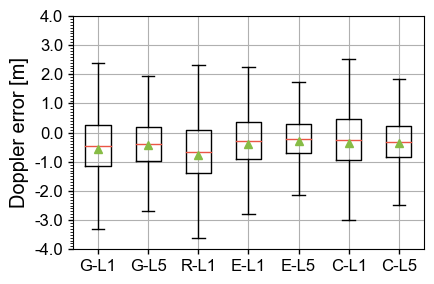

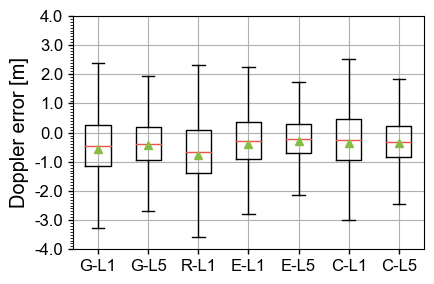

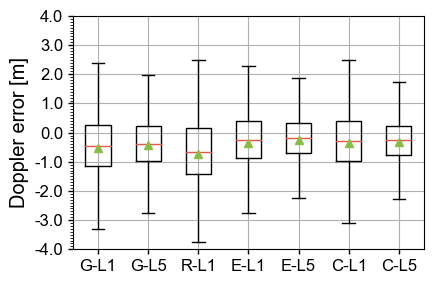

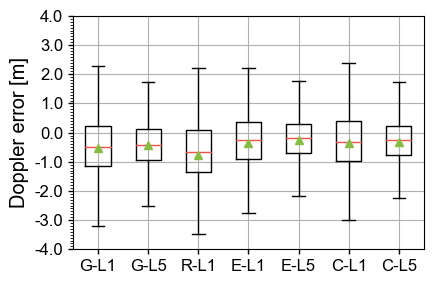

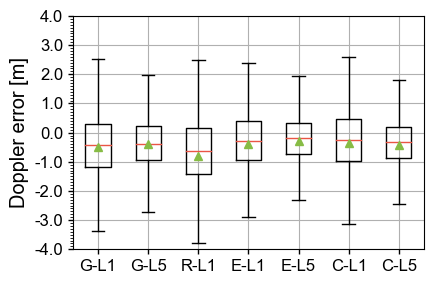

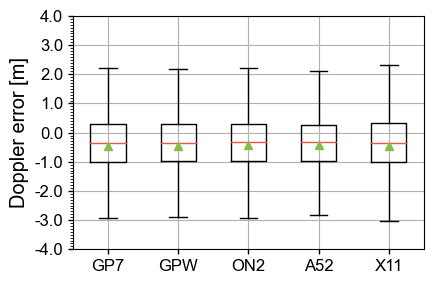

In [71]:

plotStatisticsDataBox(_logs, 
                      'doppler_error', 
                      'Doppler error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=4,
                      ticks=[0.1, 1],
                      mode='ref')

Phases

In [72]:
_logs = copy.deepcopy(logs)
stats = []
for log in _logs:
    print(f"--- {log.device} ---")
    #log.raw = misc.filterPercentile(log.raw, 'PhaseError', 0.997)
    log.raw = misc.filterValues(log.raw, 'PhaseError', 3)
    stats.append(log.raw['PhaseError'].describe(percentiles=[0.5, .667, .95, .997]).T)
stats = pd.concat(stats, keys=device_list, axis=1).T
stats

--- Pixel 7 ---
Rows removed 218 (1.718%)
--- Pixel Watch ---
Rows removed 97 (0.974%)
--- Nord 2 ---
Rows removed 1435 (9.932%)
--- A52 ---
Rows removed 0 (0.000%)
--- 11T ---
Rows removed 736 (3.909%)


,count,mean,std,min,50%,66.7%,95%,99.7%,max
Pixel 7,12470.0,0.088811,0.600464,-2.987066,0.075999,0.147407,1.075690,2.687826,2.994518
Pixel Watch,9857.0,0.118821,0.595645,-2.963115,0.098626,0.220707,1.107765,2.561065,2.958884
Nord 2,13013.0,0.342091,1.103969,-2.998955,0.390928,0.829715,2.098776,2.909660,2.999707
A52,9363.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11T,18092.0,0.090983,0.693299,-2.976545,0.077060,0.312597,1.199857,2.610205,2.999683


In [73]:
print(stats.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.3f}".format))

\begin{tabular}{rrrrrrrrr}
\toprule
    count &  mean &   std &    min &   50\% &  66.7\% &   95\% &  99.7\% &   max \\
\midrule
12470.000 & 0.089 & 0.600 & -2.987 & 0.076 &  0.147 & 1.076 &  2.688 & 2.995 \\
 9857.000 & 0.119 & 0.596 & -2.963 & 0.099 &  0.221 & 1.108 &  2.561 & 2.959 \\
13013.000 & 0.342 & 1.104 & -2.999 & 0.391 &  0.830 & 2.099 &  2.910 & 3.000 \\
 9363.000 & 0.000 & 0.000 &  0.000 & 0.000 &  0.000 & 0.000 &  0.000 & 0.000 \\
18092.000 & 0.091 & 0.693 & -2.977 & 0.077 &  0.313 & 1.200 &  2.610 & 3.000 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_854/3026797437.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.3f}".format))


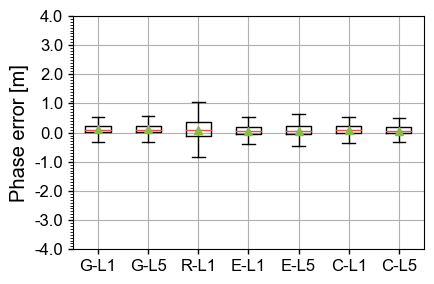

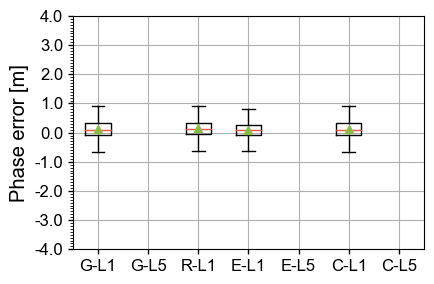

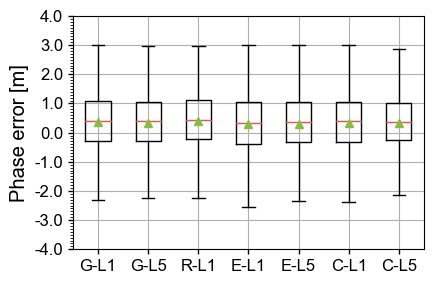

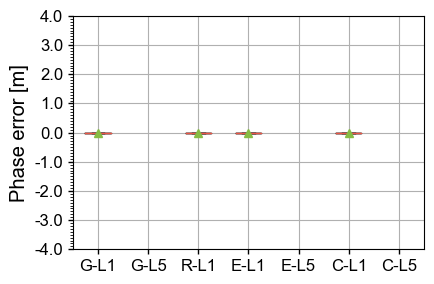

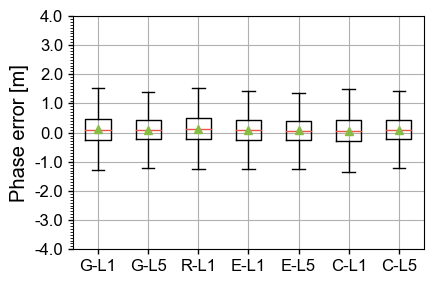

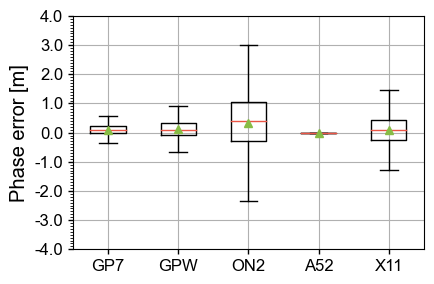

In [74]:

plotStatisticsDataBox(_logs, 
                      'PhaseError', 
                      'Phase error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=4,
                      ticks=[0.1, 1],
                      save=f"{output}/s2_phase")
    

In [75]:
_logs = copy.deepcopy(logs)
stats = []
for log in _logs:
    print(f"--- {log.device} ---")
    log.ref.df = misc.filterValues(log.ref.df, 'phase_error', 500)
    stats.append(log.ref.df['phase_error'].describe(percentiles=[0.5, .667, .95, .997]).T)
stats = pd.concat(stats, keys=device_list, axis=1).T
stats

--- Pixel 7 ---
Rows removed 1627 (6.297%)
--- Pixel Watch ---
Rows removed 1628 (6.262%)
--- Nord 2 ---
Rows removed 1751 (6.346%)
--- A52 ---
Rows removed 1745 (6.306%)
--- 11T ---
Rows removed 1596 (6.467%)


,count,mean,std,min,50%,66.7%,95%,99.7%,max
Pixel 7,24209.0,0.381272,18.915576,-498.038,0.331,0.519,1.45760,48.895072,497.996
Pixel Watch,24371.0,0.380233,18.852615,-498.038,0.330,0.516,1.45500,48.438250,497.996
Nord 2,25840.0,0.223187,20.538860,-496.858,0.323,0.501,1.35505,31.542443,482.348
A52,25926.0,0.363047,17.000730,-482.043,0.330,0.512,1.39800,44.445575,494.385
11T,23085.0,0.339827,16.733850,-496.048,0.332,0.522,1.58280,34.350316,494.432


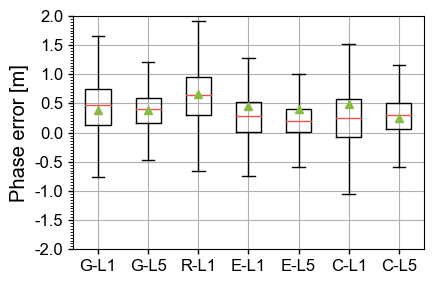

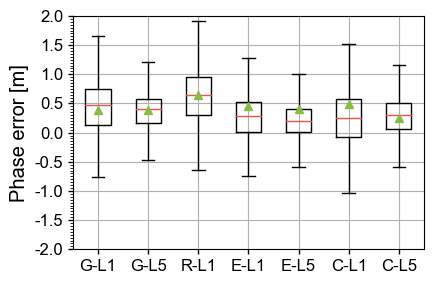

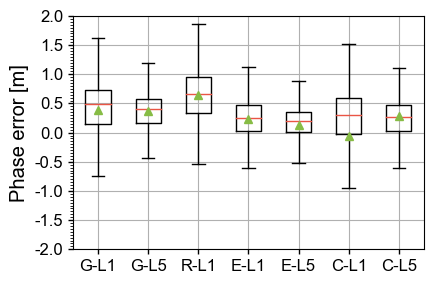

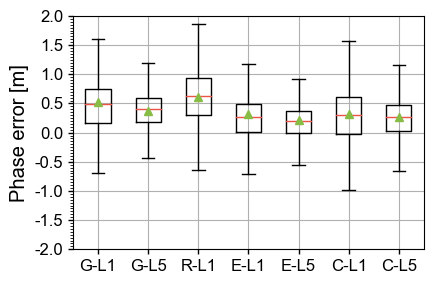

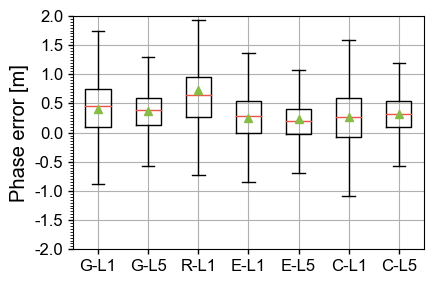

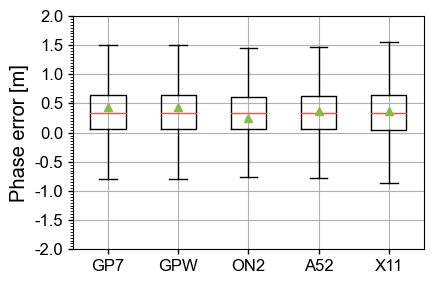

In [76]:

plotStatisticsDataBox(_logs, 
                      'phase_error', 
                      'Phase error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=2,
                      ticks=[0.05,0.5],
                      mode='ref')

In [77]:
stats = []
_logs = copy.deepcopy(logs)
for log in _logs:
    log.raw[list(misc.GnssStateADR_Str.values())] = log.raw.apply(lambda row: misc.getSplitState(row['AccumulatedDeltaRangeState'], bits=5, type='phase'), axis='columns', result_type='expand')
    count = log.raw[list(misc.GnssStateADR_Str.values())].count()
    stats.append(log.raw[list(misc.GnssStateADR_Str.values())].sum().div(count))
stats = pd.concat(stats, keys=device_list, axis=1)
stats

,Pixel 7,Pixel Watch,Nord 2,A52,11T
ADR_UNKNOWN,0.000000,0.000000,0.000000,0.0,0.000000
ADR_VALID,0.433263,0.218688,0.659256,0.0,0.684097
ADR_RESET,0.000078,0.000100,0.000000,0.0,0.000000
ADR_CYCLE_SLIP,0.029322,0.041284,0.276726,0.0,0.311901
ADR_HALF_CYCLE_RESOLVED,0.375714,0.128341,0.416083,0.0,0.437388
ADR_HALF_CYCLE_REPORTED,1.000000,1.000000,1.000000,1.0,1.000000


C/N0

In [78]:
_logs = copy.deepcopy(logs)
stats= []
for log in _logs:
    stats.append(log.raw['Cn0DbHz'].describe(percentiles=[0.5]).T)
stats = pd.concat(stats, keys=device_list, axis=1).T
stats

,count,mean,std,min,50%,max
Pixel 7,12789.0,32.741624,8.963532,10.6,33.609577,51.451855
Pixel Watch,10028.0,28.139020,6.772438,12.1,29.427770,44.306988
Nord 2,14574.0,24.778783,10.999534,0.0,27.055000,49.000000
A52,9460.0,42.821829,6.291844,21.3,43.200000,57.300000
11T,18990.0,29.476619,7.532677,5.0,30.000000,49.000000


In [79]:
print(stats.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.3f}".format))

\begin{tabular}{rrrrrr}
\toprule
    count &   mean &    std &    min &    50\% &    max \\
\midrule
12789.000 & 32.742 &  8.964 & 10.600 & 33.610 & 51.452 \\
10028.000 & 28.139 &  6.772 & 12.100 & 29.428 & 44.307 \\
14574.000 & 24.779 & 11.000 &  0.000 & 27.055 & 49.000 \\
 9460.000 & 42.822 &  6.292 & 21.300 & 43.200 & 57.300 \\
18990.000 & 29.477 &  7.533 &  5.000 & 30.000 & 49.000 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_854/3026797437.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats.to_latex(index=False, formatters={"name": str.upper}, float_format="{:.3f}".format))


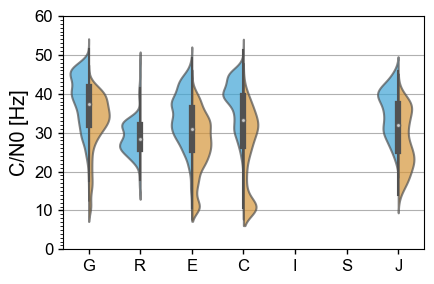

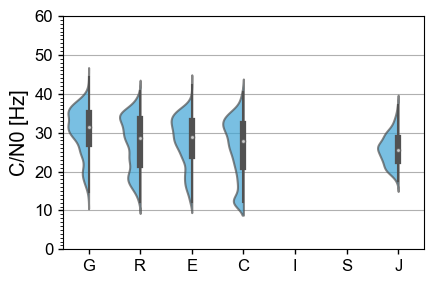

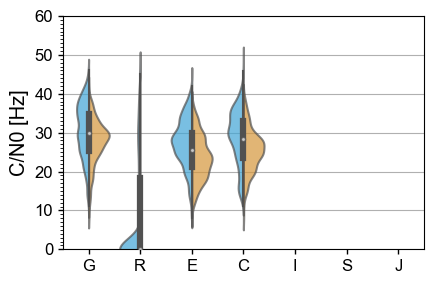

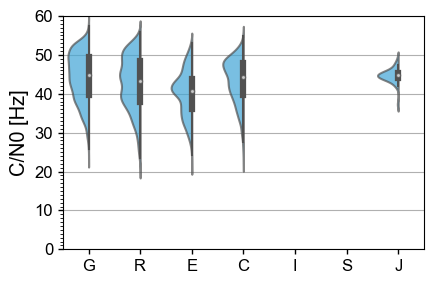

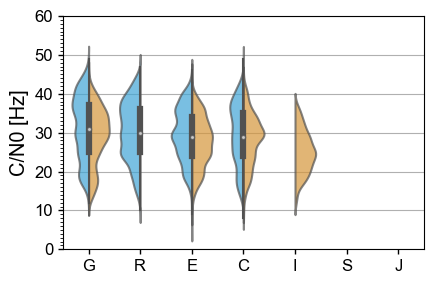

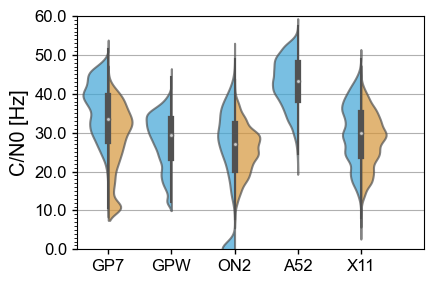

In [80]:
_logs = copy.deepcopy(logs)
plotStatisticsDataViolin(
    _logs, 
    'Cn0DbHz', 
    'C/N0 [Hz]', 
    ('G', 'R', 'E', 'C', 'I', 'S', 'J'), 
    ('L1', 'L5'),
    lim=60,
    ticks=[1,10],
    save=f"{output}/s2_cn0")

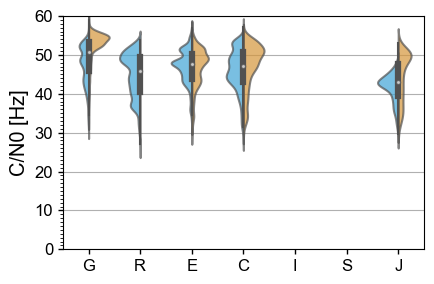

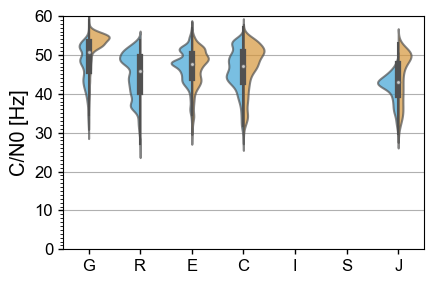

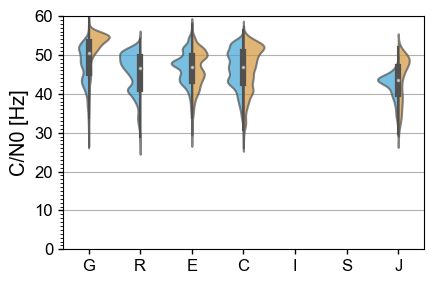

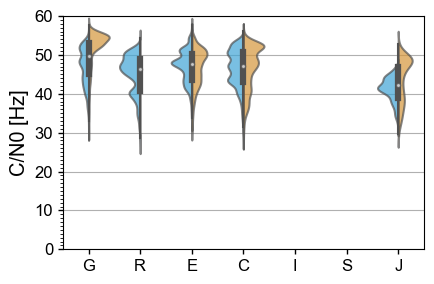

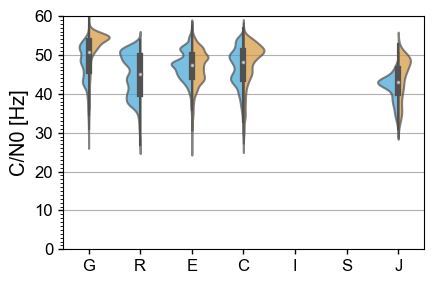

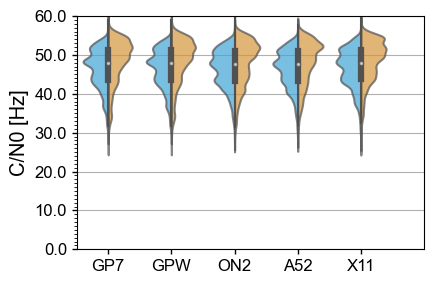

In [81]:
plotStatisticsDataViolin(
    _logs, 
    'snr', 
    'C/N0 [Hz]', 
    ('G', 'R', 'E', 'C', 'I', 'S', 'J'), 
    ('L1', 'L5'),
    lim=60,
    ticks=[1,10],
    mode='ref')